# This notebook contains experiments with increasing number of instrumental variables

In [1]:
import numpy as np
import pandas as pd
import contextlib
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import io

import os
import sys
from joblib import dump,load
from tqdm import tqdm


from experiment_utils import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)

src_path = os.path.abspath("../src")
sys.path.append(src_path)
from models import *
from utils import *

# Suppress R console output
@contextlib.contextmanager
def suppress_r_output():
    r_output = io.StringIO()
    with contextlib.redirect_stdout(r_output), contextlib.redirect_stderr(r_output):
        yield

In [2]:
def nI_trial_single(n, p, ate, df,
                          cross_fit=True, n_folds=5, ps_model='original',or_model='lr',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=True):
    
    # Run single trial with results
    ates, stds, coverage = single_trial(
        true_ate=ate, df_full=df, p=p,
        ps_model=ps_model, or_model=or_model,
        w_model=w_model,
        random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=True
    )

    all_ate = {'true_ate':ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}

    all_std = {
                'std_mr':stds['ate_mr'],
                'std_ipw':stds['ate_ipw'],
                'std_amr':stds['ate_amr'],
                'std_aipw':stds['ate_aipw']
                }
    all_coverage = {
                'coverage_mr':coverage['ate_mr'],
                'coverage_ipw':coverage['ate_ipw'],
                'coverage_amr':coverage['ate_amr'],
                'coverage_aipw':coverage['ate_aipw']
                }
    return all_ate, all_std, all_coverage


def nI_trial_causl(num_trials =200, n = 800, p_instr = 1, ate=2, strength_instr = 0.8,
                          cross_fit=True, n_folds=5, ps_model='original',or_model='original',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True):
    ate_results = {'true_ate':[],
                'ate_mr':[],
                'ate_ipw':[],
                'ate_amr':[],
                'ate_aipw':[]}

    std_results = {
                'std_mr':[],
                'std_ipw':[],
                'std_amr':[],
                'std_aipw':[]
                }
    coverage_results = {
                'coverage_mr':[],
                'coverage_ipw':[],
                'coverage_amr':[],
                'coverage_aipw':[]
                }
    for i in tqdm(range(num_trials)):
        
        random.seed(random_seed+i)
        nI = p_instr  # Fixed number of instrumental variables
        nX = 2
        nO = 2
        nS = 3
        p = nI+nX+nO+nS

        beta_cov = 0
        strength_conf = 1
        strength_outcome = 1
        df = generate_data_causl(n=n, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome)
    
        single_all_ate, single_all_std, single_all_coverage = nI_trial_single(n=n, p=p, ate=ate, df=df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i,stds_return=stds_return, coverage_return=coverage_return)
        
        for key, value in single_all_ate.items():
            ate_results[key].append(value)
        for key, value in single_all_std.items():
            std_results[key].append(value)
        for key, value in single_all_coverage.items():
            coverage_results[key].append(value)
        
    return ate_results, std_results, coverage_results

def nI_trial_synthetic(num_trials = 200, n = 800, p_instr = 1, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='original',or_model='original',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True):
    
    ate_results = {'true_ate':[],
                'ate_mr':[],
                'ate_ipw':[],
                'ate_amr':[],
                'ate_aipw':[]}

    std_results = {
                'std_mr':[],
                'std_ipw':[],
                'std_amr':[],
                'std_aipw':[]
                }
    coverage_results = {
                'coverage_mr':[],
                'coverage_ipw':[],
                'coverage_amr':[],
                'coverage_aipw':[]
                }
    for i in tqdm(range(num_trials)):
        
        random.seed(random_seed+i)
        p = 5+ p_instr
        data_mc = generate_synthetic_data(n=100000,p=p, p_instr = p_instr, strength_instrument=strength_instr, gamma=gamma, mu1_type=mu1_type)
        df = generate_synthetic_data(n=n,p=p, p_instr = p_instr, strength_instrument=strength_instr, gamma=gamma, mu1_type=mu1_type)
        ate = np.mean(data_mc['mu1'] - data_mc['mu0'])

        single_all_ate, single_all_std, single_all_coverage = nI_trial_single(n=n, p=p, ate=ate, df=df,
                          cross_fit=cross_fit, n_folds=5, ps_model=ps_model, or_model=or_model,w_model=w_model, random_seed=random_seed, stds_return=True, coverage_return=True)
        
        for key, value in single_all_ate.items():
            ate_results[key].append(value)
        for key, value in single_all_std.items():
            std_results[key].append(value)
        for key, value in single_all_coverage.items():
            coverage_results[key].append(value)
        
    return ate_results, std_results, coverage_results

In [9]:
ate_results, std_results, coverage_results = nI_trial_causl(num_trials = 200, n = 800, p_instr = 0, ate=2, strength_instr = 1, random_seed=42, cross_fit=True, n_folds = 3, ps_model='lr', or_model='lr')

ate_output_file = "results/nI/causl/ate_nI0.joblib"
std_output_file = "results/nI/causl/std_nI0.joblib"
coverage_output_file = "results/nI/causl/coverage_nI0.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [12:25<00:00,  3.73s/it]

Results saved to results/nI/causl/ate_nI0.joblib
Results saved to results/nI/causl/std_nI0.joblib
Results saved to results/nI/causl/coverage_nI0.joblib


In [ ]:
ate_results, std_results, coverage_results = nI_trial_causl(num_trials = 200, n = 800, p_instr = 2, ate=2, strength_instr = 1, random_seed=42, cross_fit=True, n_folds = 3, ps_model='lr', or_model='lr')

ate_output_file = "results/nI/causl/ate_nI2.joblib"
std_output_file = "results/nI/causl/std_nI2.joblib"
coverage_output_file = "results/nI/causl/coverage_nI2.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

In [ ]:
ate_results, std_results, coverage_results = nI_trial_causl(num_trials = 200, n = 800, p_instr = 4, ate=2, strength_instr = 1, random_seed=42, cross_fit=True,n_folds = 3, ps_model='lr', or_model='lr')

ate_output_file = "results/nI/causl/ate_nI4.joblib"
std_output_file = "results/nI/causl/std_nI4.joblib"
coverage_output_file = "results/nI/causl/coverage_nI4.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

In [ ]:
ate_results, std_results, coverage_results = nI_trial_causl(num_trials = 200, n = 800, p_instr = 6, ate=2, strength_instr = 1, random_seed=42, cross_fit=True, n_folds = 3, ps_model='lr', or_model='lr')

ate_output_file = "results/nI/causl/ate_nI6.joblib"
std_output_file = "results/nI/causl/std_nI6.joblib"
coverage_output_file = "results/nI/causl/coverage_nI6.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

In [ ]:
ate_results, std_results, coverage_results = nI_trial_causl(num_trials = 200, n = 800, p_instr = 8, ate=2, strength_instr = 1, random_seed=42, cross_fit=True, n_folds = 3, ps_model='lr', or_model='lr')
ate_output_file = "results/nI/causl/ate_nI8.joblib"
std_output_file = "results/nI/causl/std_nI8.joblib"
coverage_output_file = "results/nI/causl/coverage_nI8.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

In [12]:
ate_results, std_results, coverage_results = nI_trial_causl(num_trials = 200, n = 800, p_instr = 10, ate=2, strength_instr = 1, random_seed=42, cross_fit=True,n_folds = 3, ps_model='lr', or_model='lr')

ate_output_file = "results/nI/causl/ate_nI10.joblib"
std_output_file = "results/nI/causl/std_nI10.joblib"
coverage_output_file = "results/nI/causl/coverage_nI10.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [12:45<00:00,  3.83s/it]

Results saved to results/nI/causl/ate_nI10.joblib
Results saved to results/nI/causl/std_nI10.joblib
Results saved to results/nI/causl/coverage_nI10.joblib


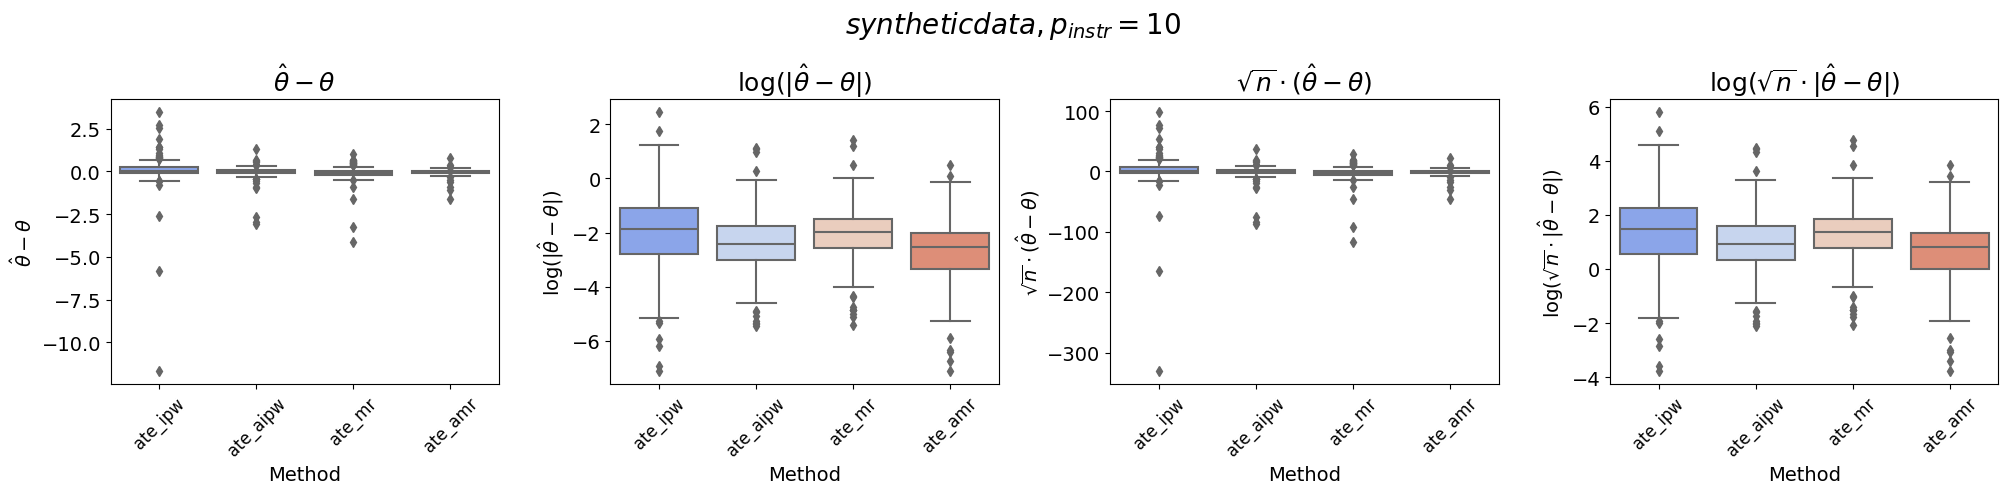

     Method  Mean_Diff  Std_Diff  Mean_Abs_Diff  Std_Abs_Diff      RMSE  \
0   ate_ipw   0.053714  1.071370       0.378808      1.003606  1.072716   
1  ate_aipw  -0.051397  0.414485       0.182207      0.375819  0.417659   
2    ate_mr  -0.107323  0.443067       0.219406      0.399609  0.455880   
3   ate_amr  -0.048541  0.197984       0.112990      0.169668  0.203848   

   Std_RMSE  
0  2.142741  
1  0.828969  
2  0.886134  
3  0.395969  


In [19]:
ate_results = load("results/nI/causl/ate_nI10.joblib")
# Extract keys and true ATE
methods = ['ate_ipw', 'ate_aipw', 'ate_mr', 'ate_amr']
short_methods = {'ate_ipw': 'IPW', 'ate_aipw': 'AIPW', 'ate_mr': 'MR', 'ate_amr': 'AMR'}

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 800
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle(r'$synthetic data, p_{instr}=10$',fontsize=20)
plt.tight_layout()
plt.show()

summary_stats=[]
# Compute summary statistics
for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [17]:
ate_results, std_results, coverage_results = nI_trial_causl(num_trials = 200, n = 800, p_instr = 20, ate=2, strength_instr = 1, random_seed=42, cross_fit=True,n_folds = 3, ps_model='lr', or_model='lr')

ate_output_file = "results/nI/causl/ate_nI20.joblib"
std_output_file = "results/nI/causl/std_nI20.joblib"
coverage_output_file = "results/nI/causl/coverage_nI20.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [14:52<00:00,  4.46s/it]

Results saved to results/nI/causl/ate_nI20.joblib
Results saved to results/nI/causl/std_nI20.joblib
Results saved to results/nI/causl/coverage_nI20.joblib


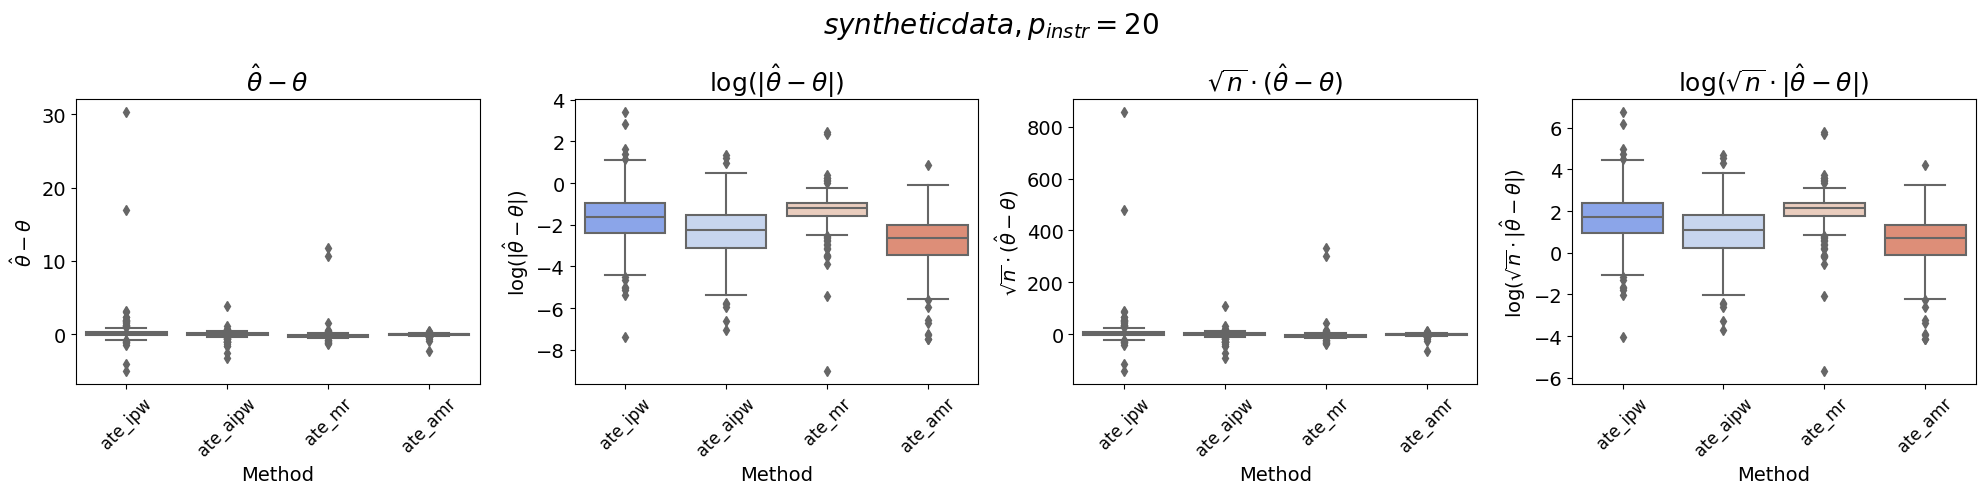

     Method  Mean_Diff  Std_Diff  Mean_Abs_Diff  Std_Abs_Diff      RMSE  \
0   ate_ipw   0.311408  2.556830       0.641459      2.494571  2.575724   
1  ate_aipw  -0.052793  0.521946       0.241209      0.465868  0.524610   
2    ate_mr  -0.161853  1.172632       0.423124      1.105544  1.183749   
3   ate_amr  -0.061091  0.211651       0.108801      0.191548  0.220291   

   Std_RMSE  
0  5.113660  
1  1.043893  
2  2.345264  
3  0.423302  


In [18]:
# Extract keys and true ATE
methods = ['ate_ipw', 'ate_aipw', 'ate_mr', 'ate_amr']
short_methods = {'ate_ipw': 'IPW', 'ate_aipw': 'AIPW', 'ate_mr': 'MR', 'ate_amr': 'AMR'}

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 800
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle(r'$synthetic  data, p_{instr}=20$',fontsize=20)
plt.tight_layout()
plt.show()

summary_stats=[]
# Compute summary statistics
for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



# Synthetic data v1

In [34]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 200,  n = 800, p_instr = 0, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
ate_output_file = "results/nI/synthetic/ate_nI0.joblib"
std_output_file = "results/nI/synthetic/std_nI0.joblib"
coverage_output_file = "results/nI/synthetic/coverage_nI0.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [24:27<00:00,  7.34s/it]

Results saved to results/nI/synthetic/ate_nI0.joblib
Results saved to results/nI/synthetic/std_nI0.joblib
Results saved to results/nI/synthetic/coverage_nI0.joblib


In [11]:
from joblib import load
import numpy as np
coverage_nI0 = load("results/nI/synthetic/coverage_nI0.joblib")
std_nI0 = load("results/nI/synthetic/std_nI0.joblib")
print("coverage,amr ",np.mean(coverage_nI0['coverage_amr']))
print("std,amr ", np.mean(std_nI0['std_amr']))
print("coverage,aipw ",np.mean(coverage_nI0['coverage_aipw']))
print("std,aipw", np.mean(std_nI0['std_aipw']))

coverage,amr  0.99
std,amr  2.6230239059759084
coverage,aipw  0.96
std,aipw 2.416321983521992


## Increase data size

In [6]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 20,  n = 4000, p_instr = 0, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
# ate_output_file = "results/nI/synthetic/ate_nI0.joblib"
# std_output_file = "results/nI/synthetic/std_nI0.joblib"
# coverage_output_file = "results/nI/synthetic/coverage_nI0.joblib"
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")
# dump(coverage_results, coverage_output_file)
# print(f"Results saved to {coverage_output_file}")

100%|██████████| 20/20 [38:55<00:00, 116.76s/it]


In [7]:
print("coverage,amr ",np.mean(coverage_results['coverage_amr']))
print("std,amr ", np.mean(std_results['std_amr']))
print("coverage,aipw ",np.mean(coverage_results['coverage_aipw']))
print("std,aipw", np.mean(std_results['std_aipw']))

coverage,amr  0.95
std,amr  1.1569857651197775
coverage,aipw  0.95
std,aipw 1.0731219550017237


## Temp: modify influence func

In [3]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 200,  n = 800, p_instr = 0, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
# ate_output_file = "results/nI/synthetic/ate_nI0.joblib"
# std_output_file = "results/nI/synthetic/std_nI0.joblib"
# coverage_output_file = "results/nI/synthetic/coverage_nI0.joblib"
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")
# dump(coverage_results, coverage_output_file)
# print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [21:23<00:00,  6.42s/it]


In [5]:
print("coverage,amr ",np.mean(coverage_results['coverage_amr']))
print("std,amr ", np.mean(std_results['std_amr']))
print("coverage,aipw ",np.mean(coverage_results['coverage_aipw']))
print("std,aipw", np.mean(std_results['std_aipw']))

coverage,amr  0.93
std,amr  2.40932452764207
coverage,aipw  0.93
std,aipw 2.410500809644064


# nI=5

In [33]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 200,  n = 800, p_instr = 5, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
ate_output_file = "results/nI/synthetic/ate_nI5.joblib"
std_output_file = "results/nI/synthetic/std_nI5.joblib"
coverage_output_file = "results/nI/synthetic/coverage_nI5.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [25:39<00:00,  7.70s/it]

Results saved to results/nI/synthetic/ate_nI5.joblib
Results saved to results/nI/synthetic/std_nI5.joblib
Results saved to results/nI/synthetic/coverage_nI5.joblib


In [24]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 200,  n = 800, p_instr = 10, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
ate_output_file = "results/nI/synthetic/ate_nI10.joblib"
std_output_file = "results/nI/synthetic/std_nI10.joblib"
coverage_output_file = "results/nI/synthetic/coverage_nI10.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [27:08<00:00,  8.14s/it]

Results saved to results/nI/synthetic/ate_nI0.joblib
Results saved to results/nI/synthetic/std_nI0.joblib
Results saved to results/nI/synthetic/coverage_nI0.joblib


# nI=10

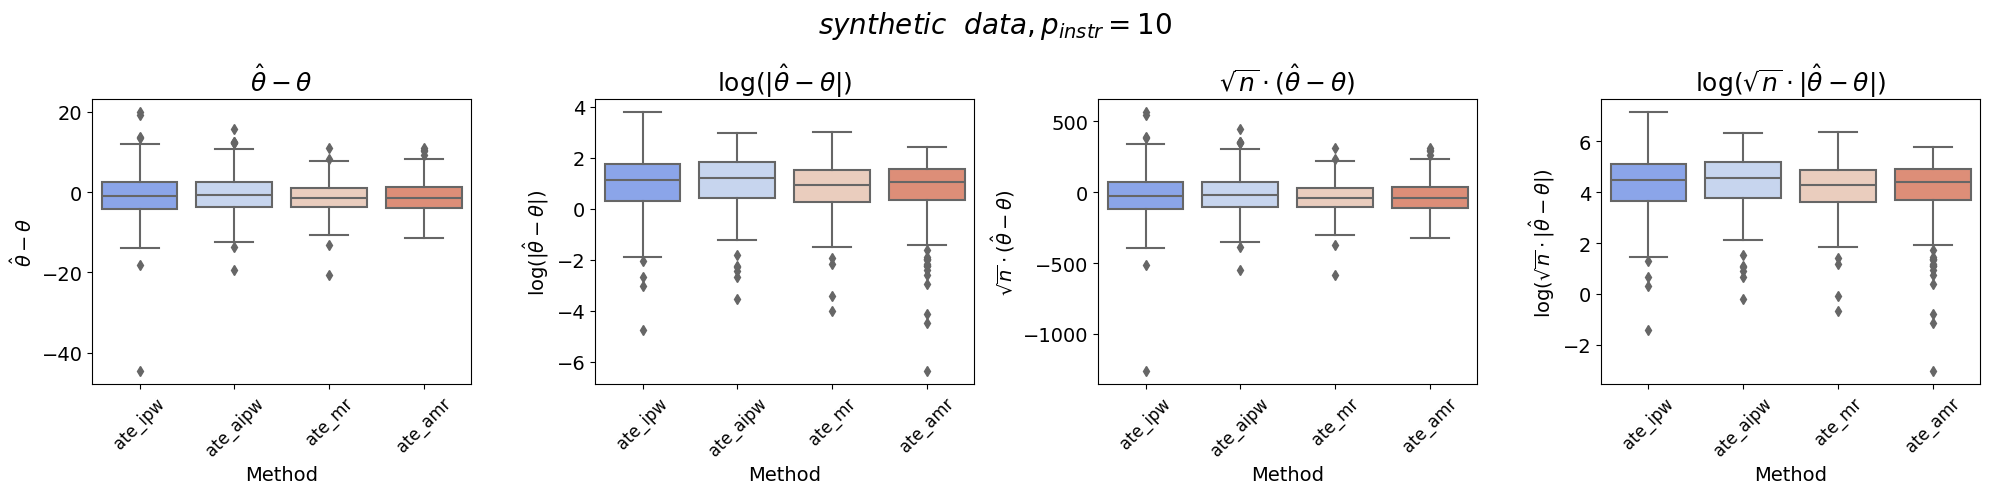

     Method  Mean_Diff  Std_Diff  Mean_Abs_Diff  Std_Abs_Diff      RMSE  \
0   ate_ipw  -0.890956  6.378591       4.424319      4.680345  6.440515   
1  ate_aipw  -0.649150  5.569721       4.346676      3.542541  5.607423   
2    ate_mr  -1.551960  3.974951       3.284049      2.724672  4.267179   
3   ate_amr  -1.308256  4.039678       3.368252      2.585616  4.246237   

    Std_RMSE  
0  12.757183  
1  11.139442  
2   7.949901  
3   8.079356  


In [31]:
# Extract keys and true ATE
ate_results = load("results/nI/synthetic/ate_nI10.joblib")
methods = ['ate_ipw', 'ate_aipw', 'ate_mr', 'ate_amr']
short_methods = {'ate_ipw': 'IPW', 'ate_aipw': 'AIPW', 'ate_mr': 'MR', 'ate_amr': 'AMR'}

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 800
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle(r'$synthetic\ \  data, p_{instr}=10$',fontsize=20)
plt.tight_layout()
plt.show()

summary_stats=[]
# Compute summary statistics
for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



# nI=15

In [32]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 200,  n = 800, p_instr = 15, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
ate_output_file = "results/nI/synthetic/ate_nI15.joblib"
std_output_file = "results/nI/synthetic/std_nI15.joblib"
coverage_output_file = "results/nI/synthetic/coverage_nI15.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [28:32<00:00,  8.56s/it]

Results saved to results/nI/synthetic/ate_nI15.joblib
Results saved to results/nI/synthetic/std_nI15.joblib
Results saved to results/nI/synthetic/coverage_nI15.joblib


In [3]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 30,  n = 4000, p_instr = 15, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
ate_output_file = "results/nI/synthetic/ate_nI15_n4000.joblib"
std_output_file = "results/nI/synthetic/std_nI15_n4000.joblib"
coverage_output_file = "results/nI/synthetic/coverage_nI15_n4000.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 30/30 [58:54<00:00, 117.82s/it] 

Results saved to results/nI/synthetic/ate_nI15_n4000.joblib
Results saved to results/nI/synthetic/std_nI15_n4000.joblib
Results saved to results/nI/synthetic/coverage_nI15_n4000.joblib


In [5]:
print("coverage,amr ",np.mean(coverage_results['coverage_amr']))
print("std,amr ", np.mean(std_results['std_amr']))
print("coverage,aipw ",np.mean(coverage_results['coverage_aipw']))
print("std,aipw", np.mean(std_results['std_aipw']))

coverage,amr  0.9
std,amr  4.063321516510018
coverage,aipw  0.9333333333333333
std,aipw 3.5876331097595093


# nI=20

In [26]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 200,  n = 800, p_instr = 20, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
ate_output_file = "results/nI/synthetic/ate_nI20.joblib"
std_output_file = "results/nI/synthetic/std_nI20.joblib"
coverage_output_file = "results/nI/synthetic/coverage_nI20.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
dump(coverage_results, coverage_output_file)
print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [28:34<00:00,  8.57s/it]

Results saved to results/nI/synthetic/ate_nI20.joblib
Results saved to results/nI/synthetic/std_nI20.joblib
Results saved to results/nI/synthetic/coverage_nI20.joblib


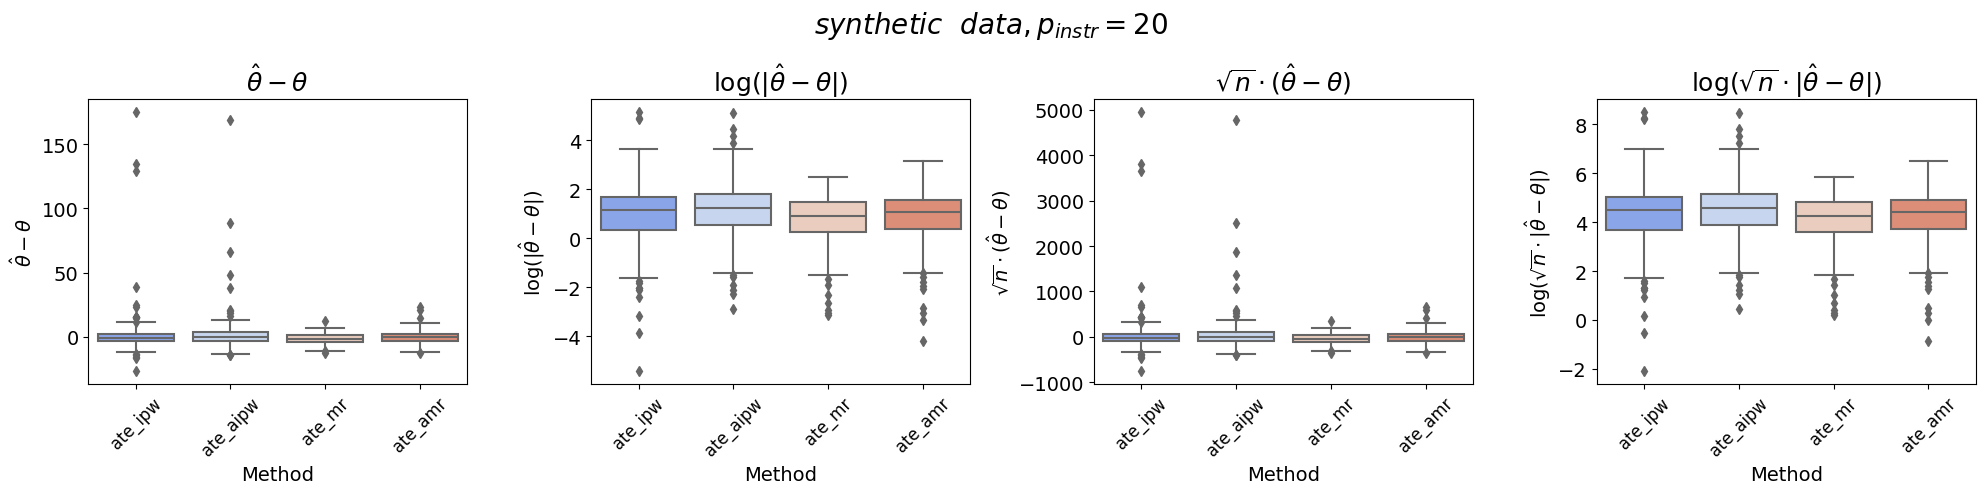

     Method  Mean_Diff   Std_Diff  Mean_Abs_Diff  Std_Abs_Diff       RMSE  \
0   ate_ipw   1.798914  19.166286       6.595670     18.085346  19.250522   
1  ate_aipw   1.874057  15.834872       6.251627     14.668757  15.945384   
2    ate_mr  -1.487273   3.684486       3.109355      2.473727   3.973338   
3   ate_amr  -0.346412   4.859291       3.616334      3.264175   4.871623   

    Std_RMSE  
0  38.332571  
1  31.669744  
2   7.368972  
3   9.718582  


In [28]:
# Extract keys and true ATE
methods = ['ate_ipw', 'ate_aipw', 'ate_mr', 'ate_amr']
short_methods = {'ate_ipw': 'IPW', 'ate_aipw': 'AIPW', 'ate_mr': 'MR', 'ate_amr': 'AMR'}

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 800
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle(r'$synthetic\ \  data, p_{instr}=20$',fontsize=20)
plt.tight_layout()
plt.show()

summary_stats=[]
# Compute summary statistics
for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



## Modify coverage calculation

In [6]:
ate_results, std_results, coverage_results = nI_trial_synthetic(num_trials = 200,  n = 800, p_instr = 20, ate=2, strength_instr = 0.8, gamma=10, mu1_type = 'non_linear',
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',w_model='kernel_ridge_regression', random_seed=42,stds_return=True, coverage_return=True)
# ate_output_file = "results/nI/synthetic/ate_nI20.joblib"
# std_output_file = "results/nI/synthetic/std_nI20.joblib"
# coverage_output_file = "results/nI/synthetic/coverage_nI20.joblib"
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")
# dump(coverage_results, coverage_output_file)
# print(f"Results saved to {coverage_output_file}")

100%|██████████| 200/200 [23:36<00:00,  7.08s/it]


In [7]:
print("coverage,amr ",np.mean(coverage_results['coverage_amr']))
print("std,amr ", np.mean(std_results['std_amr']))
print("coverage,aipw ",np.mean(coverage_results['coverage_aipw']))
print("std,aipw", np.mean(std_results['std_aipw']))

coverage,amr  0.935
std,amr  6.3487091209404865
coverage,aipw  0.885
std,aipw 6.350855811529397


# Combine all results together

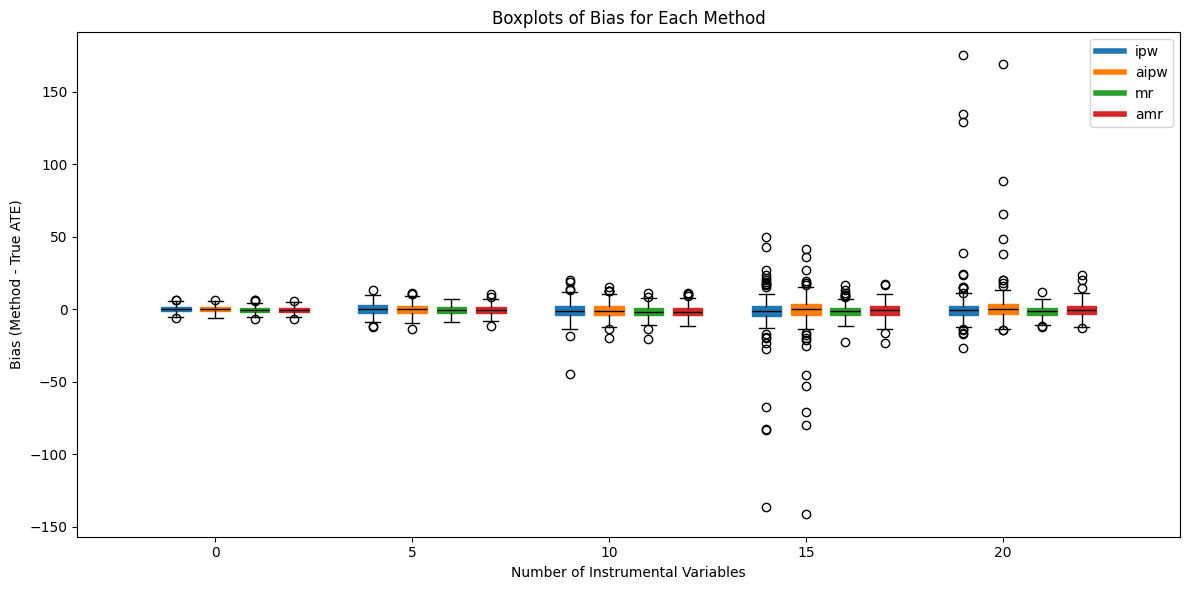

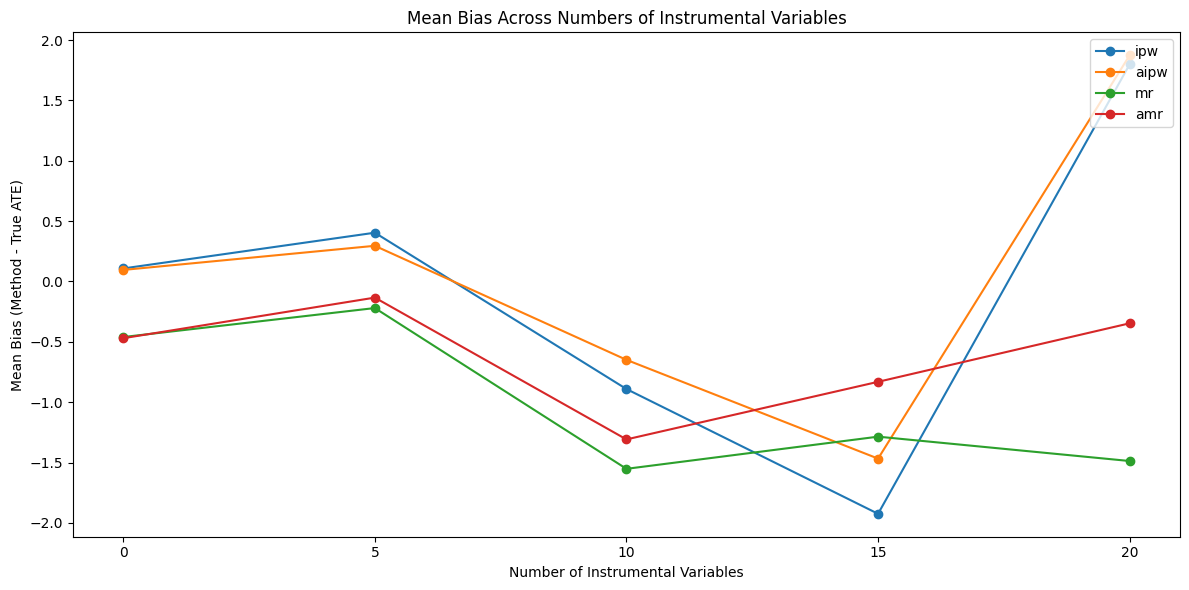

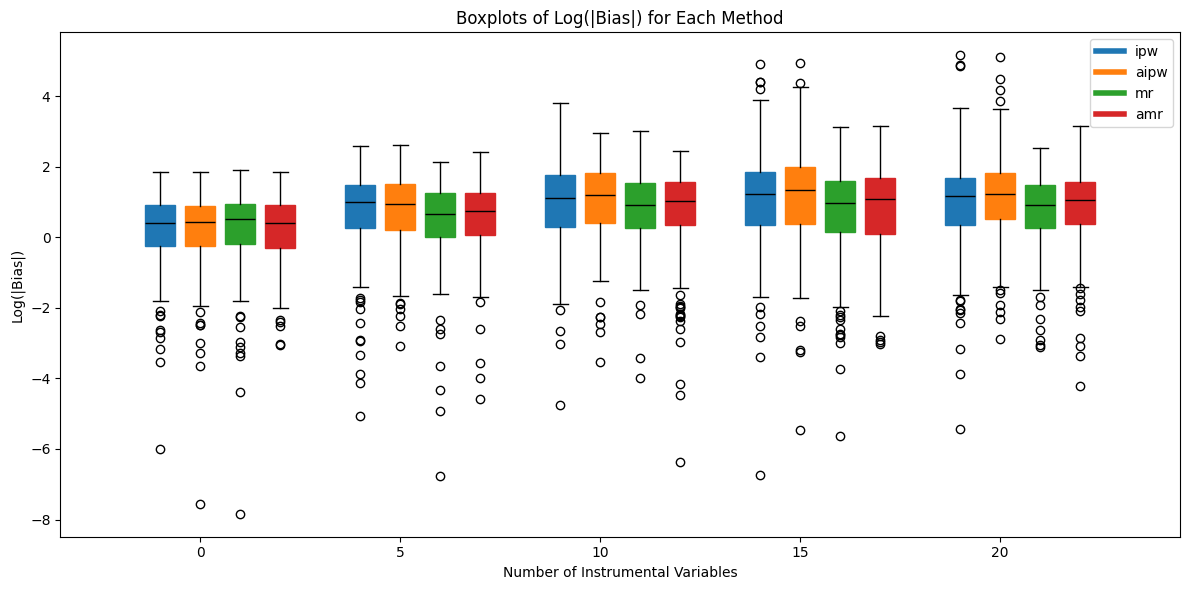

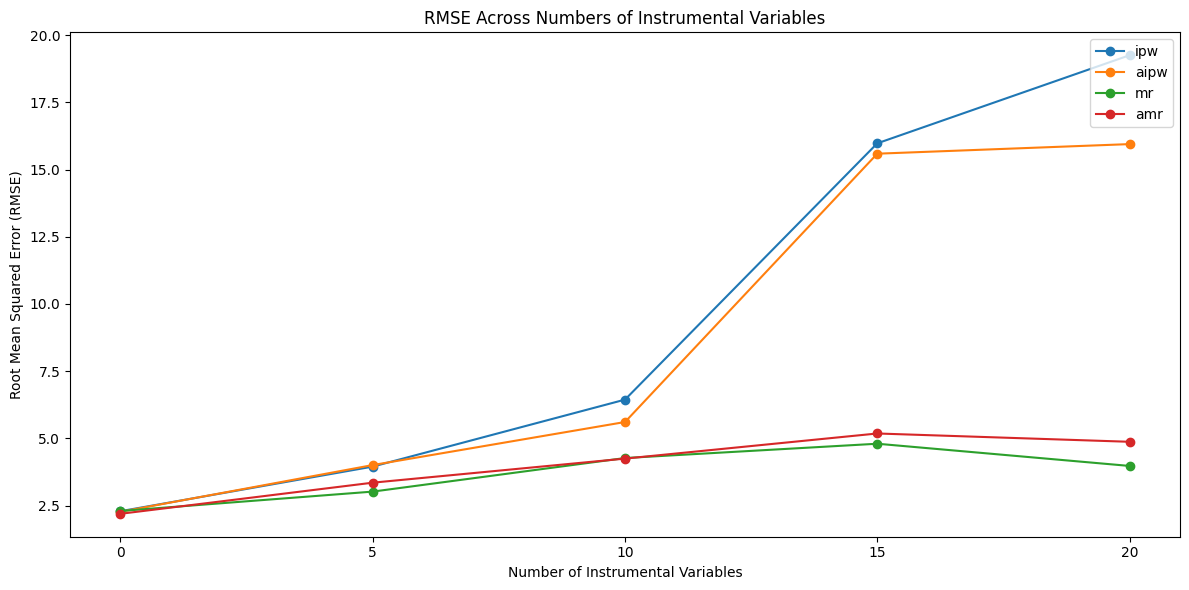

In [40]:
import os
import joblib
import matplotlib.pyplot as plt
import numpy as np

# File pattern and nums to iterate
base_path = "results/nI/synthetic/ate_nI"
nums = [0, 5, 10, 15, 20]

# Initialize container for results
ate_results = {}

# Load files
for num in nums:
    file_path = f"{base_path}{num}.joblib"
    if os.path.exists(file_path):
        ate_results[num] = joblib.load(file_path)
    else:
        print(f"File not found: {file_path}")

# Prepare the data
if ate_results:
    # Define the desired method order
    desired_order = ["ipw", "aipw", "mr", "amr"]
    T_methods = [f"ate_{method}" for method in desired_order if f"ate_{method}" in ate_results[next(iter(ate_results))].keys()]
    boxplot_data = {method: [] for method in T_methods}
    true_ate_values = []

    for num in nums:
        if num in ate_results:
            true_ate = ate_results[num]["true_ate"]
            true_ate_values.append(true_ate)
            for method in T_methods:
                boxplot_data[method].append(
                    np.array(ate_results[num][method]) - np.array(true_ate)
                )  # Calculate bias

    # Plotting
    x_ticks = nums
    colors = plt.cm.tab10(range(len(T_methods)))  # Different colors for each method
    method_labels = [method.replace("ate_", "") for method in T_methods]  # Drop prefix

    # 4.1 Boxplot of bias
    plt.figure(figsize=(12, 6))
    for idx, method in enumerate(T_methods):
        data = [boxplot_data[method][i] for i in range(len(x_ticks))]
        positions = np.arange(len(x_ticks)) + idx * 0.2 - 0.2
        plt.boxplot(data, positions=positions, widths=0.15, patch_artist=True,
                    boxprops=dict(facecolor=colors[idx], color=colors[idx]),
                    medianprops=dict(color='black'))
    plt.xticks(ticks=np.arange(len(x_ticks)), labels=x_ticks)
    plt.xlabel("Number of Instrumental Variables")
    plt.ylabel("Bias (Method - True ATE)")
    plt.title("Boxplots of Bias for Each Method")
    plt.legend([plt.Line2D([0], [0], color=colors[idx], lw=4) for idx in range(len(T_methods))],
               method_labels, loc="upper right")
    plt.tight_layout()
    plt.show()

    # 4.2 Line plot of mean bias
    plt.figure(figsize=(12, 6))
    for idx, method in enumerate(T_methods):
        mean_bias = [np.mean(boxplot_data[method][i]) for i in range(len(x_ticks))]
        plt.plot(x_ticks, mean_bias, label=method_labels[idx], color=colors[idx], marker='o')
    plt.xticks(ticks=x_ticks)
    plt.xlabel("Number of Instrumental Variables")
    plt.ylabel("Mean Bias (Method - True ATE)")
    plt.title("Mean Bias Across Numbers of Instrumental Variables")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # 4.3 Boxplot of log(|bias|)
    plt.figure(figsize=(12, 6))
    for idx, method in enumerate(T_methods):
        data = [np.log(np.abs(boxplot_data[method][i])) for i in range(len(x_ticks))]
        positions = np.arange(len(x_ticks)) + idx * 0.2 - 0.2
        plt.boxplot(data, positions=positions, widths=0.15, patch_artist=True,
                    boxprops=dict(facecolor=colors[idx], color=colors[idx]),
                    medianprops=dict(color='black'))
    plt.xticks(ticks=np.arange(len(x_ticks)), labels=x_ticks)
    plt.xlabel("Number of Instrumental Variables")
    plt.ylabel("Log(|Bias|)")
    plt.title("Boxplots of Log(|Bias|) for Each Method")
    plt.legend([plt.Line2D([0], [0], color=colors[idx], lw=4) for idx in range(len(T_methods))],
               method_labels, loc="upper right")
    plt.tight_layout()
    plt.show()

    # 4.4 Line plot of RMSE
    plt.figure(figsize=(12, 6))
    for idx, method in enumerate(T_methods):
        rmse = [np.sqrt(np.mean(boxplot_data[method][i]**2)) for i in range(len(x_ticks))]
        plt.plot(x_ticks, rmse, label=method_labels[idx], color=colors[idx], marker='o')
    plt.xticks(ticks=x_ticks)
    plt.xlabel("Number of Instrumental Variables")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.title("RMSE Across Numbers of Instrumental Variables")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
else:
    print("No data loaded to plot.")


In [41]:

# Define the range for p_instr
p_instr_range = range(0, 11, 1)

# Loop over the range of p_instr
for p_instr in p_instr_range:
    # Run the synthetic trial with varying p_instr
    ate_results, std_results, coverage_results = nI_trial_synthetic(
        num_trials=200,
        n=500,
        p_instr=p_instr,
        ate=2,
        strength_instr=0.8,
        gamma=10,
        mu1_type='non_linear',
        cross_fit=True,
        n_folds=5,
        ps_model='original',
        or_model='lr',
        w_model='kernel_ridge_regression',
        random_seed=42,
        stds_return=True,
        coverage_return=True
    )
    
    # Define output file names with dynamic p_instr value
    ate_output_file = f"results/nI/synthetic/ps_original_ate_nI{p_instr}.joblib"
    std_output_file = f"results/nI/synthetic/ps_original_std_nI{p_instr}.joblib"
    coverage_output_file = f"results/nI/synthetic/ps_original_coverage_nI{p_instr}.joblib"
    
    # Ensure directories exist
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(coverage_output_file), exist_ok=True)
    
    # Save results to files
    dump(ate_results, ate_output_file)
    print(f"ATE results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"STD results saved to {std_output_file}")
    dump(coverage_results, coverage_output_file)
    print(f"Coverage results saved to {coverage_output_file}")


100%|██████████| 200/200 [18:11<00:00,  5.46s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI0.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI0.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI0.joblib


100%|██████████| 200/200 [18:48<00:00,  5.64s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI1.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI1.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI1.joblib


100%|██████████| 200/200 [20:07<00:00,  6.04s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI2.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI2.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI2.joblib


100%|██████████| 200/200 [17:32<00:00,  5.26s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI3.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI3.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI3.joblib


100%|██████████| 200/200 [19:12<00:00,  5.76s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI4.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI4.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI4.joblib


100%|██████████| 200/200 [17:29<00:00,  5.25s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI5.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI5.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI5.joblib


100%|██████████| 200/200 [19:29<00:00,  5.85s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI6.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI6.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI6.joblib


100%|██████████| 200/200 [17:18<00:00,  5.19s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI7.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI7.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI7.joblib


100%|██████████| 200/200 [17:54<00:00,  5.37s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI8.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI8.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI8.joblib


100%|██████████| 200/200 [16:43<00:00,  5.02s/it]


ATE results saved to results/nI/synthetic/ps_original_ate_nI9.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI9.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI9.joblib


100%|██████████| 200/200 [19:50<00:00,  5.95s/it]

ATE results saved to results/nI/synthetic/ps_original_ate_nI10.joblib
STD results saved to results/nI/synthetic/ps_original_std_nI10.joblib
Coverage results saved to results/nI/synthetic/ps_original_coverage_nI10.joblib


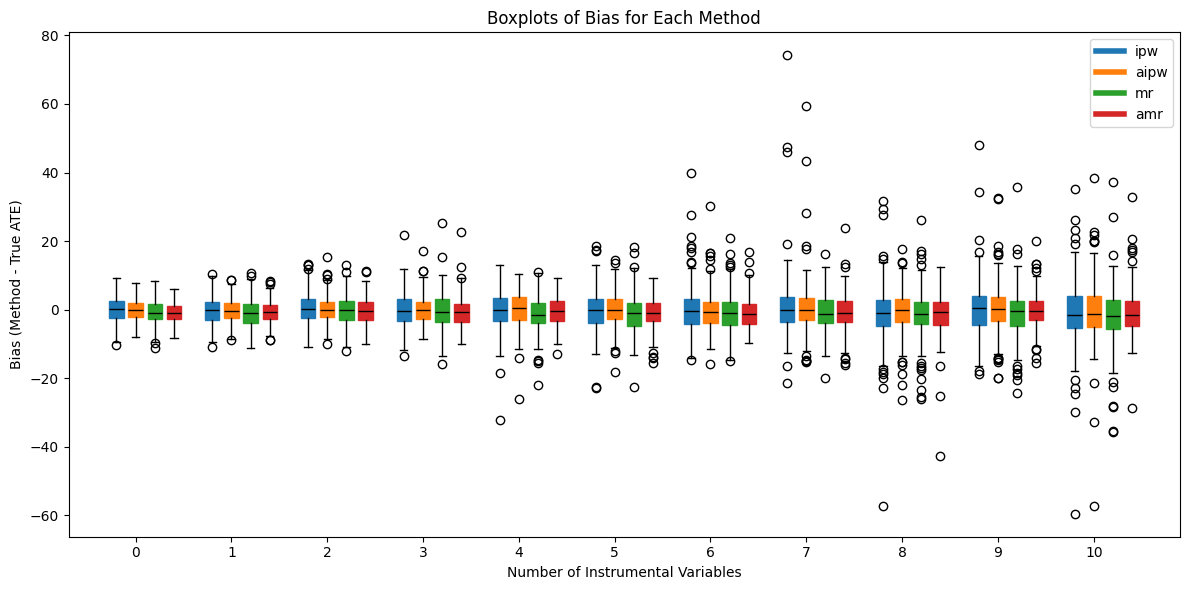

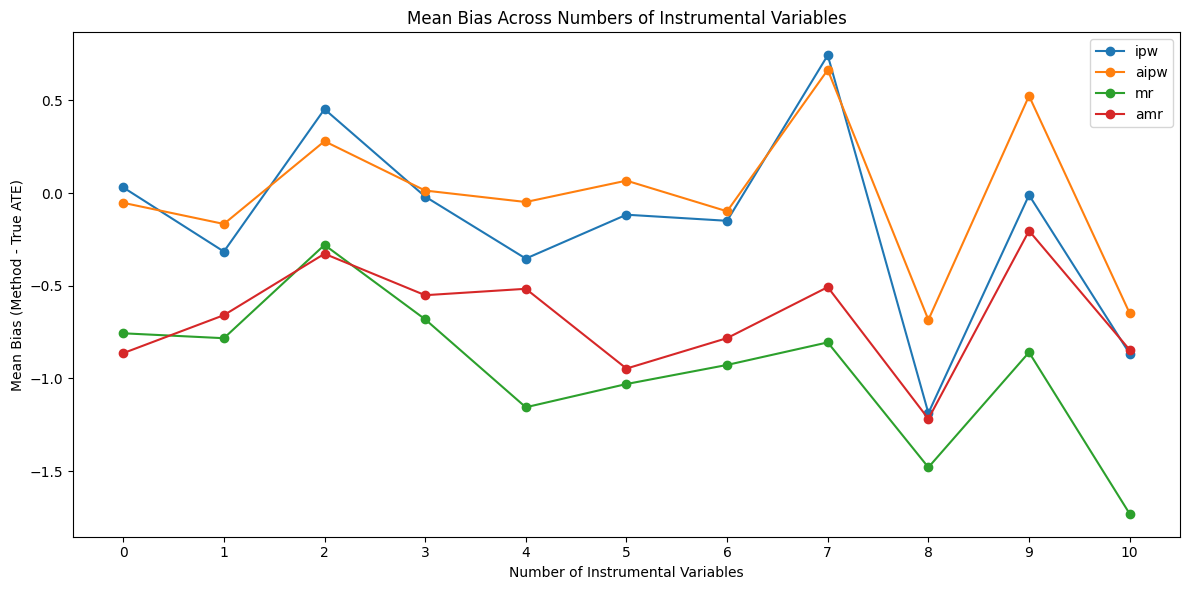

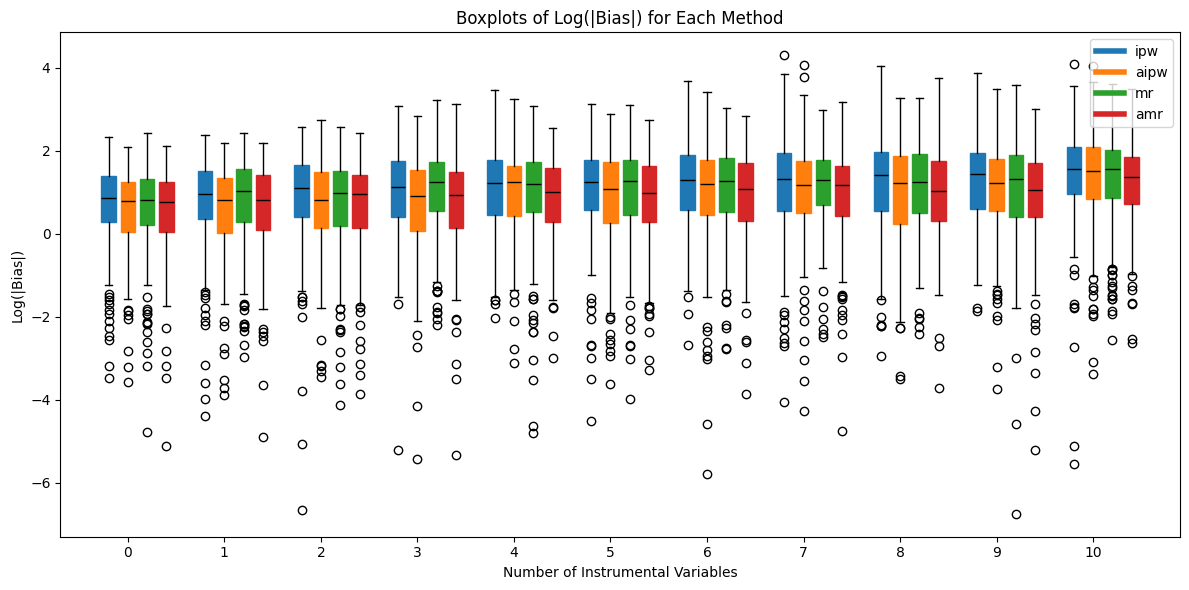

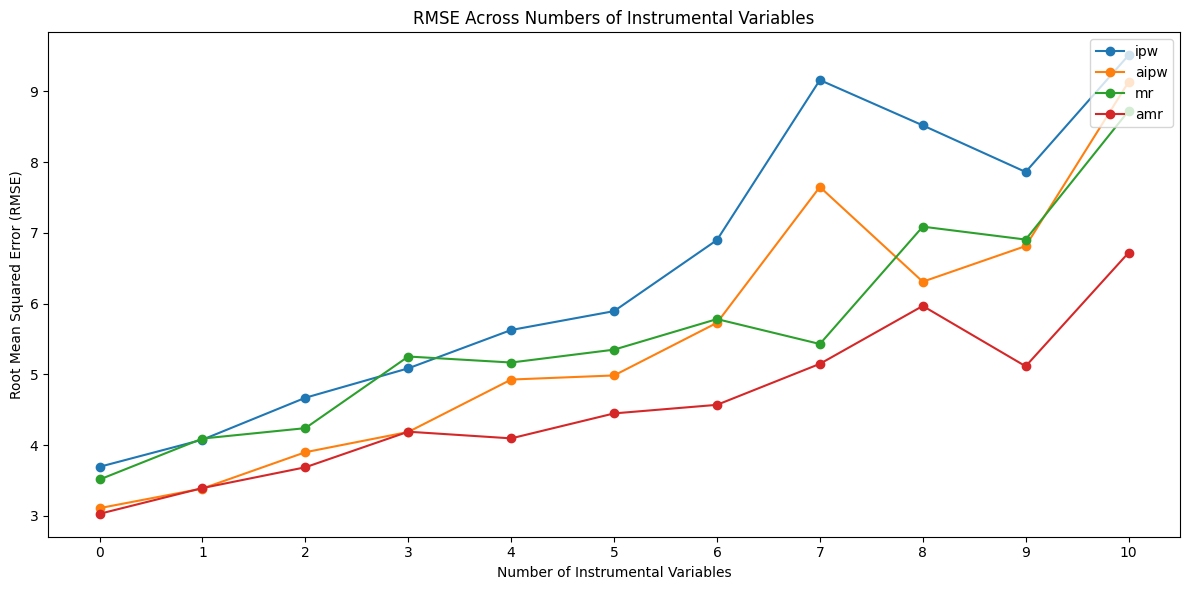

In [ ]:
# File pattern and nums to iterate
base_path = "results/nI/synthetic/ps_original_ate_nI"
nums = range(0,11,1)

# Initialize container for results
ate_results = {}

# Load files
for num in nums:
    file_path = f"{base_path}{num}.joblib"
    if os.path.exists(file_path):
        ate_results[num] = joblib.load(file_path)
    else:
        print(f"File not found: {file_path}")

# Prepare the data
if ate_results:
    # Define the desired method order
    desired_order = ["ipw", "aipw", "mr", "amr"]
    T_methods = [f"ate_{method}" for method in desired_order if f"ate_{method}" in ate_results[next(iter(ate_results))].keys()]
    boxplot_data = {method: [] for method in T_methods}
    true_ate_values = []

    for num in nums:
        if num in ate_results:
            true_ate = ate_results[num]["true_ate"]
            true_ate_values.append(true_ate)
            for method in T_methods:
                boxplot_data[method].append(
                    np.array(ate_results[num][method]) - np.array(true_ate)
                )  # Calculate bias

    # Plotting
    x_ticks = nums
    colors = plt.cm.tab10(range(len(T_methods)))  # Different colors for each method
    method_labels = [method.replace("ate_", "") for method in T_methods]  # Drop prefix

    # 4.1 Boxplot of bias
    plt.figure(figsize=(12, 6))
    for idx, method in enumerate(T_methods):
        data = [boxplot_data[method][i] for i in range(len(x_ticks))]
        positions = np.arange(len(x_ticks)) + idx * 0.2 - 0.2
        plt.boxplot(data, positions=positions, widths=0.15, patch_artist=True,
                    boxprops=dict(facecolor=colors[idx], color=colors[idx]),
                    medianprops=dict(color='black'))
    plt.xticks(ticks=np.arange(len(x_ticks)), labels=x_ticks)
    plt.xlabel("Number of Instrumental Variables")
    plt.ylabel("Bias (Method - True ATE)")
    plt.title("Boxplots of Bias for Each Method")
    plt.legend([plt.Line2D([0], [0], color=colors[idx], lw=4) for idx in range(len(T_methods))],
               method_labels, loc="upper right")
    plt.tight_layout()
    plt.show()

    # 4.2 Line plot of mean bias
    plt.figure(figsize=(12, 6))
    for idx, method in enumerate(T_methods):
        mean_bias = [np.mean(boxplot_data[method][i]) for i in range(len(x_ticks))]
        plt.plot(x_ticks, mean_bias, label=method_labels[idx], color=colors[idx], marker='o')
    plt.xticks(ticks=x_ticks)
    plt.xlabel("Number of Instrumental Variables")
    plt.ylabel("Mean Bias (Method - True ATE)")
    plt.title("Mean Bias Across Numbers of Instrumental Variables")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # 4.3 Boxplot of log(|bias|)
    plt.figure(figsize=(12, 6))
    for idx, method in enumerate(T_methods):
        data = [np.log(np.abs(boxplot_data[method][i])) for i in range(len(x_ticks))]
        positions = np.arange(len(x_ticks)) + idx * 0.2 - 0.2
        plt.boxplot(data, positions=positions, widths=0.15, patch_artist=True,
                    boxprops=dict(facecolor=colors[idx], color=colors[idx]),
                    medianprops=dict(color='black'))
    plt.xticks(ticks=np.arange(len(x_ticks)), labels=x_ticks)
    plt.xlabel("Number of Instrumental Variables")
    plt.ylabel("Log(|Bias|)")
    plt.title("Boxplots of Log(|Bias|) for Each Method")
    plt.legend([plt.Line2D([0], [0], color=colors[idx], lw=4) for idx in range(len(T_methods))],
               method_labels, loc="upper right")
    plt.tight_layout()
    plt.show()

    # 4.4 Line plot of RMSE
    plt.figure(figsize=(12, 6))
    for idx, method in enumerate(T_methods):
        rmse = [np.sqrt(np.mean(boxplot_data[method][i]**2)) for i in range(len(x_ticks))]
        plt.plot(x_ticks, rmse, label=method_labels[idx], color=colors[idx], marker='o')
    plt.xticks(ticks=x_ticks)
    plt.xlabel("Number of Instrumental Variables")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.title("RMSE Across Numbers of Instrumental Variables")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
else:
    print("No data loaded to plot.")
